Log-Gabor Filter
==========

This is an implementation of the Log-Gabor Filter.

In [1]:
# Common imports (you may not end up using all of them)
import numpy as np
import numpy.fft as fft
import scipy.ndimage as ndi
import skimage as ski
import skimage.io as io
import skimage.exposure as ex
import matplotlib.pylab as plt
import math

import skimage.filters as filters

plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

In [2]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


In [3]:
# Utilities

def fft_convolve(im1, im2):
  '''
  Convolves two images by converting them into fourier space and multiplying them.

  Arguments:
    im1 the first image to convolve
    im2 the second image to convolve

  Returns:
    the result of the convolution.
  '''
  return fft.ifft2(
      fft.fft2(im1) *
      fft.fft2(im2, s=im1.shape)
  ).real

In [4]:
def create_log_gabor_x_y(size):
    '''
    Creates the x and y parts of the log gabor filter

    Arguments:
        size        size (width and height) of the kernel

    Returns:
        the x and y parts
    '''
    
    if size < 3 or size % 2 == 0 or (not isinstance(size, int)):
        raise ValueError('size is invalid value: ' + str(size))

    num_rows = size
    num_cols = size

    x = np.arange(-(num_cols // 2), (num_cols // 2) + 1) / num_cols
    y = np.arange(-(num_rows // 2), (num_rows // 2) + 1) / num_rows
    [x,y] = np.meshgrid(x, y)

    return x, y

In [5]:
def create_log_gabor_radial_component(x, y, size, wavelength, sigma):
    '''
    Convolves two images by converting them into fourier space and multiplying them.

    Arguments:
        x
        y
        size 
        wavelength  determined the frequency
        sigma

    Returns:
        a 2D numpy image representing the radial component of a log-gabor filter
    '''

    num_rows = size
    num_cols = size

    radius = np.sqrt(x**2 + y**2)

    radius[(num_rows // 2), (num_cols // 2)] = 1

    frequency = 1.0 / wavelength

    radial_component = np.exp((-(np.log(radius/frequency)) ** 2) / (2 * (np.log(sigma) ** 2)))
    radial_component[num_rows // 2, num_cols // 2] = 0

    # TODO: skipping low pass filter for now

    return radial_component


In [6]:
def create_log_gabor_angular_component(x, y, angle, theta_sigma):
    '''
    a 2D numpy image with the shape (size, size) representing the angular component of a log-gabor filter

    Arguments:
        x
        y
        angle
        theta_sigma

    Returns:
        an image representing the angular component of a Log-Gabor filter
    '''
    # calculate the angular component that controls the orientation selectivity of the filter.
    theta = np.arctan2(-y, x)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    # difference in sine and cosine
    diff_sin = sin_theta * np.cos(angle) - cos_theta * np.sin(angle)
    diff_cos = cos_theta * np.cos(angle) + sin_theta * np.sin(angle)

    # calculate absolute angular distance
    distance_theta = np.abs(np.arctan2(diff_sin, diff_cos))

    # calc angular component
    angular_component = np.exp((-distance_theta ** 2) / (2 * (theta_sigma ** 2)))
    
    return angular_component

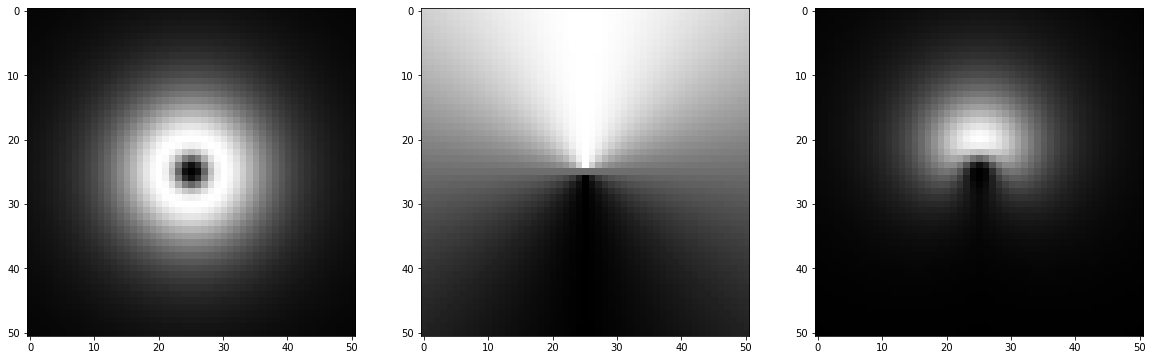

In [7]:
def create_log_gabor_kernel(frequency, size=7, wavelength=3, sigma=0.5, angle=np.pi/2, theta_sigma=1.25):
    '''
    Convolves two images by converting them into fourier space and multiplying them.

    Arguments:
        frequency
        size        size (width and height) of the kernel
        wavelength  
        sigma

    Returns:
        a log-gabor kernel
        '''

    x, y = create_log_gabor_x_y(size)
    radial_component = create_log_gabor_radial_component(x, y, size, wavelength, sigma)
    angular_component = create_log_gabor_angular_component(x, y, angle, theta_sigma)
    final_kernel = angular_component * radial_component

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(radial_component)

    plt.subplot(1, 3, 2)
    plt.imshow(angular_component)

    plt.subplot(1, 3, 3)
    plt.imshow(final_kernel)

    return final_kernel

create_log_gabor_kernel(0.5, size=51, wavelength=10)
pass


In [22]:
#  sigmaOnf  .85   mult 1.3
#  sigmaOnf  .75   mult 1.6     (bandwidth ~1 octave)
#  sigmaOnf  .65   mult 2.1
#  sigmaOnf  .55   mult 3       (bandwidth ~2 octaves)

def create_log_gabor_filter_bank(size, min_wave_length=10, sigma=0.55, scaling_factor=3, num_scales=5, num_orientations=6, theta_sigma=1.5):
    if min_wave_length < 3:
        raise ValueError('min_wave_length must at least be 3. It is: ' + str(min_wave_length))

    # max_wavelength = min_wave_length * (scaling ** (num_scales - 1))

    x, y = create_log_gabor_x_y(size)

    angular_components = []
    for orientation in range(num_orientations):
        angle = 2 * math.pi * (orientation / num_orientations)
        ac = create_log_gabor_angular_component(x, y, angle, theta_sigma)
        angular_components.append(ac)

    radial_components = []
    wavelength = min_wave_length
    for _ in range(num_scales):
        rc = create_log_gabor_radial_component(x, y, size, wavelength, sigma)
        radial_components.append(rc)

        wavelength *= scaling_factor

    filter_bank = []
    for rc in radial_components:
        for ac in angular_components:
            filter_bank.append(rc * ac)
    return filter_bank


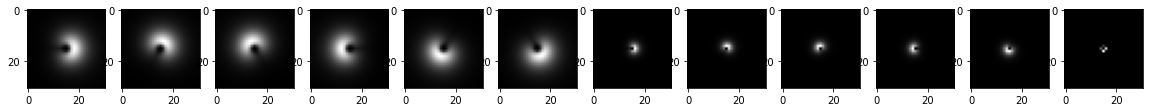

In [25]:

random_filter_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 29]

filter_bank = create_log_gabor_filter_bank(31)

plt.figure(figsize=(20, 20))

for i, filter_value in enumerate(random_filter_values):
    plt.subplot(1, len(random_filter_values), i+1)
    plt.imshow(filter_bank[filter_value])


In [26]:
def apply_filter_bank(im, filter_bank):
    accumulation = np.ones(shape=im.shape)
    for k in filter_bank:
        accumulation = np.maximum(accumulation, ndi.convolve(im, k))
    return accumulation


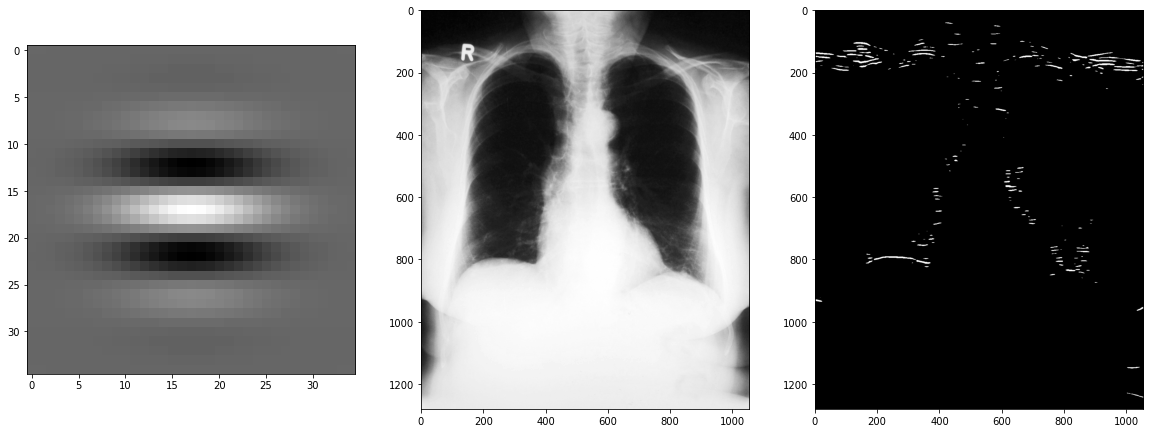

In [79]:
im = io.imread('ImageProcessingF2021/images/xray.png')

k = filters.gabor_kernel(0.1, 2 * math.pi * (24 / 32)).real

plt.figure(figsize=(20, 20))

num_cols = 3

plt.subplot(1, num_cols, 1)
plt.imshow(k)

plt.subplot(1, num_cols, 2)
plt.imshow(im)

plt.subplot(1, num_cols, 3)
plt.imshow(ndi.convolve(im, k))